### Modified by Brian Rose

to use [intake-esm](https://intake-esm.readthedocs.io/en/latest/) for the data ingestion step (and hopefully be a bit more explicit and easier to generalize to other data)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

# from dask.distributed import Client
# from dask_kubernetes import KubeCluster

# cluster = KubeCluster()
# cluster.adapt(minimum=1, maximum=20, interval='2s')
# client = Client(cluster)
# client

In [3]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

## The task at hand

- Loop through the `source_id` for `experiment_id == 'historical'`
- For each model:
    - select only a single ensemble member (at least for now)
    - Take a slice `time=slice('1981', '2010')` and compute time average over that slice (date range consistent with the long-term climatology of the NCEP reanalysis, to which we are comparing
    - Regrid the `tas` data to a common grid
    - drop redundant variables (like "height: 2m")
    - concatenate to ensemble dataset along `ensemble` dimension

In [4]:
#  Define the common target grid axes
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 2.)),
                     'lon': (['lon'], np.arange(0.5, 360., 2.)),
                    }
                   )

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [5]:
varnames = ['tas','psl','pr','uas','vas']

ensdict = {}
for varname in tqdm(varnames):
    cat = col.search(experiment_id='historical', 
                     table_id='Amon', 
                     variable_id=varname,
                     member_id='r1i1p1f1'  # choose first ensemble member only (for now)
                    )

    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

    ensdict[varname] = {}
    for key, ds in tqdm(dset_dict.items()):
        # rename spatial dimensions if necessary
        if ('longitude' in ds.dims) and ('latitude' in ds.dims):
            ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        ds = xr.decode_cf(ds)
        # take 1980-2019 mean
        timeave = ds.sel(time=slice('1981', '2010')).mean(dim='time')  # date range consistent with reanalysis long-term-mean
        # regrid to common 2deg by 2deg grid
        ds_new = regrid_to_common(timeave[varname], ds_out)
        
        # Maks out MCM-UA due to broken units (Ron Stouffer, personal communication)
        if ('MCM-UA' in ds.attrs['parent_source_id']) and (varname == 'pr'):
            ds_new = ds_new.where(False)
        
        ds_new.attrs['name'] = ds.attrs['source_id']
        # drop redundant variables (like "height: 2m")
        for coord in ds_new.coords:
            if coord not in ['lat','lon']:
                ds_new = ds_new.drop(coord)
                
        # Add ensemble as new dimension
        ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
        
        # Add var as new dimension
        ds_new = ds_new.expand_dims({'var': np.array([varname])}, 0)
        
        # We should keep the metadata!!!
        
        ensdict[varname][key] = ds_new  # add this to the dictionary

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 19 group(s)


Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_180x360_89x180_peri.nc
Reuse existing file: bilinear_256x512_89x180_peri.nc
Reuse existing file: bilinear_143x144_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_96x192_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_80x96_89x180_peri.nc



Reuse existing file: bilinear_192x384_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_80x180_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_180x360_89x180_peri.nc
Reuse existing file: bilinear_256x512_89x180_peri.nc
Reuse existing file: bilinear_143x144_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_96x192_89x180_peri.nc


Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_80x180_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_180x360_89x180_peri.nc
Reuse existing file: bilinear_256x512_89x180_peri.nc
Reuse existing file: bilinear_143x144_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_96x192_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc


Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_256x512_89x180_peri.nc
Reuse existing file: bilinear_143x144_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_96x192_89x180_peri.nc
Reuse existing file: bilinear_80x96_89x180_peri.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 14 group(s)


Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_256x512_89x180_peri.nc
Reuse existing file: bilinear_143x144_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_96x192_89x180_peri.nc
Reuse existing file: bilinear_80x96_89x180_peri.nc




In [6]:
ens = xr.concat([
    xr.concat([ds for name, ds in ensdict[varname].items()], dim='ensemble')
    for varname in varnames
],dim='var')

ens.name = "CMIP6"
ens = ens.squeeze()

## Some data to compare against!

We will use long-term mean climatology from NCEP reanalysis (because it's easy)

In [7]:
# Paths gotten from:
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surface.html
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_paths_dict = {"tas": "surface/air.mon.ltm.nc",
                   "psl": "surface/slp.mon.ltm.nc",
                   "pr": "surface_gauss/prate.sfc.mon.ltm.nc",
                   "uas": "surface/uwnd.mon.ltm.nc",
                   "vas": "surface/vwnd.mon.ltm.nc"}

def convert_ncep_units_to_cf(da):
    if da.attrs['units'] == "degC":
        da += 273.15
        da.attrs['units'] = "K"
    elif da.attrs['units'] == "millibars":
        da *= 100.
        da.attrs['units'] = "Pa"
    return da

ncep_list = []
for varname, path in ncep_paths_dict.items():
    ncep_ds = xr.open_dataset(ncep_url + path)
    ncep_var_name = path.split("/")[1].split(".")[0]
    
    # Long-term monthly climatology 1981-2010
    ncep_var_native = ncep_ds[ncep_var_name]
    
    # Convert NCEP data to CF units
    ncep_var_native = convert_ncep_units_to_cf(ncep_var_native)
    
    # Long-term mean 1981-2010
    ncep_var_native = ncep_var_native.mean(dim='time')
        
    # Regrid to common 1deg by 1deg grid
    ncep_var_regridded = regrid_to_common(ncep_var_native, ds_out)
    
    # keep all the original attributes
    ncep_var_regridded.attrs.update(ncep_ds.attrs) 
    
    # Expand dimensions
    ncep_var_regridded = ncep_var_regridded.expand_dims({'var': np.array([varname])}, 0)

    ncep_list.append(ncep_var_regridded)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_89x180_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_89x180_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_94x192_89x180_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_89x180_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_89x180_peri.nc


In [8]:
ncep = xr.concat([ds for ds in ncep_list], dim='var')
ncep.name = "NCEP"

<Figure size 432x288 with 0 Axes>

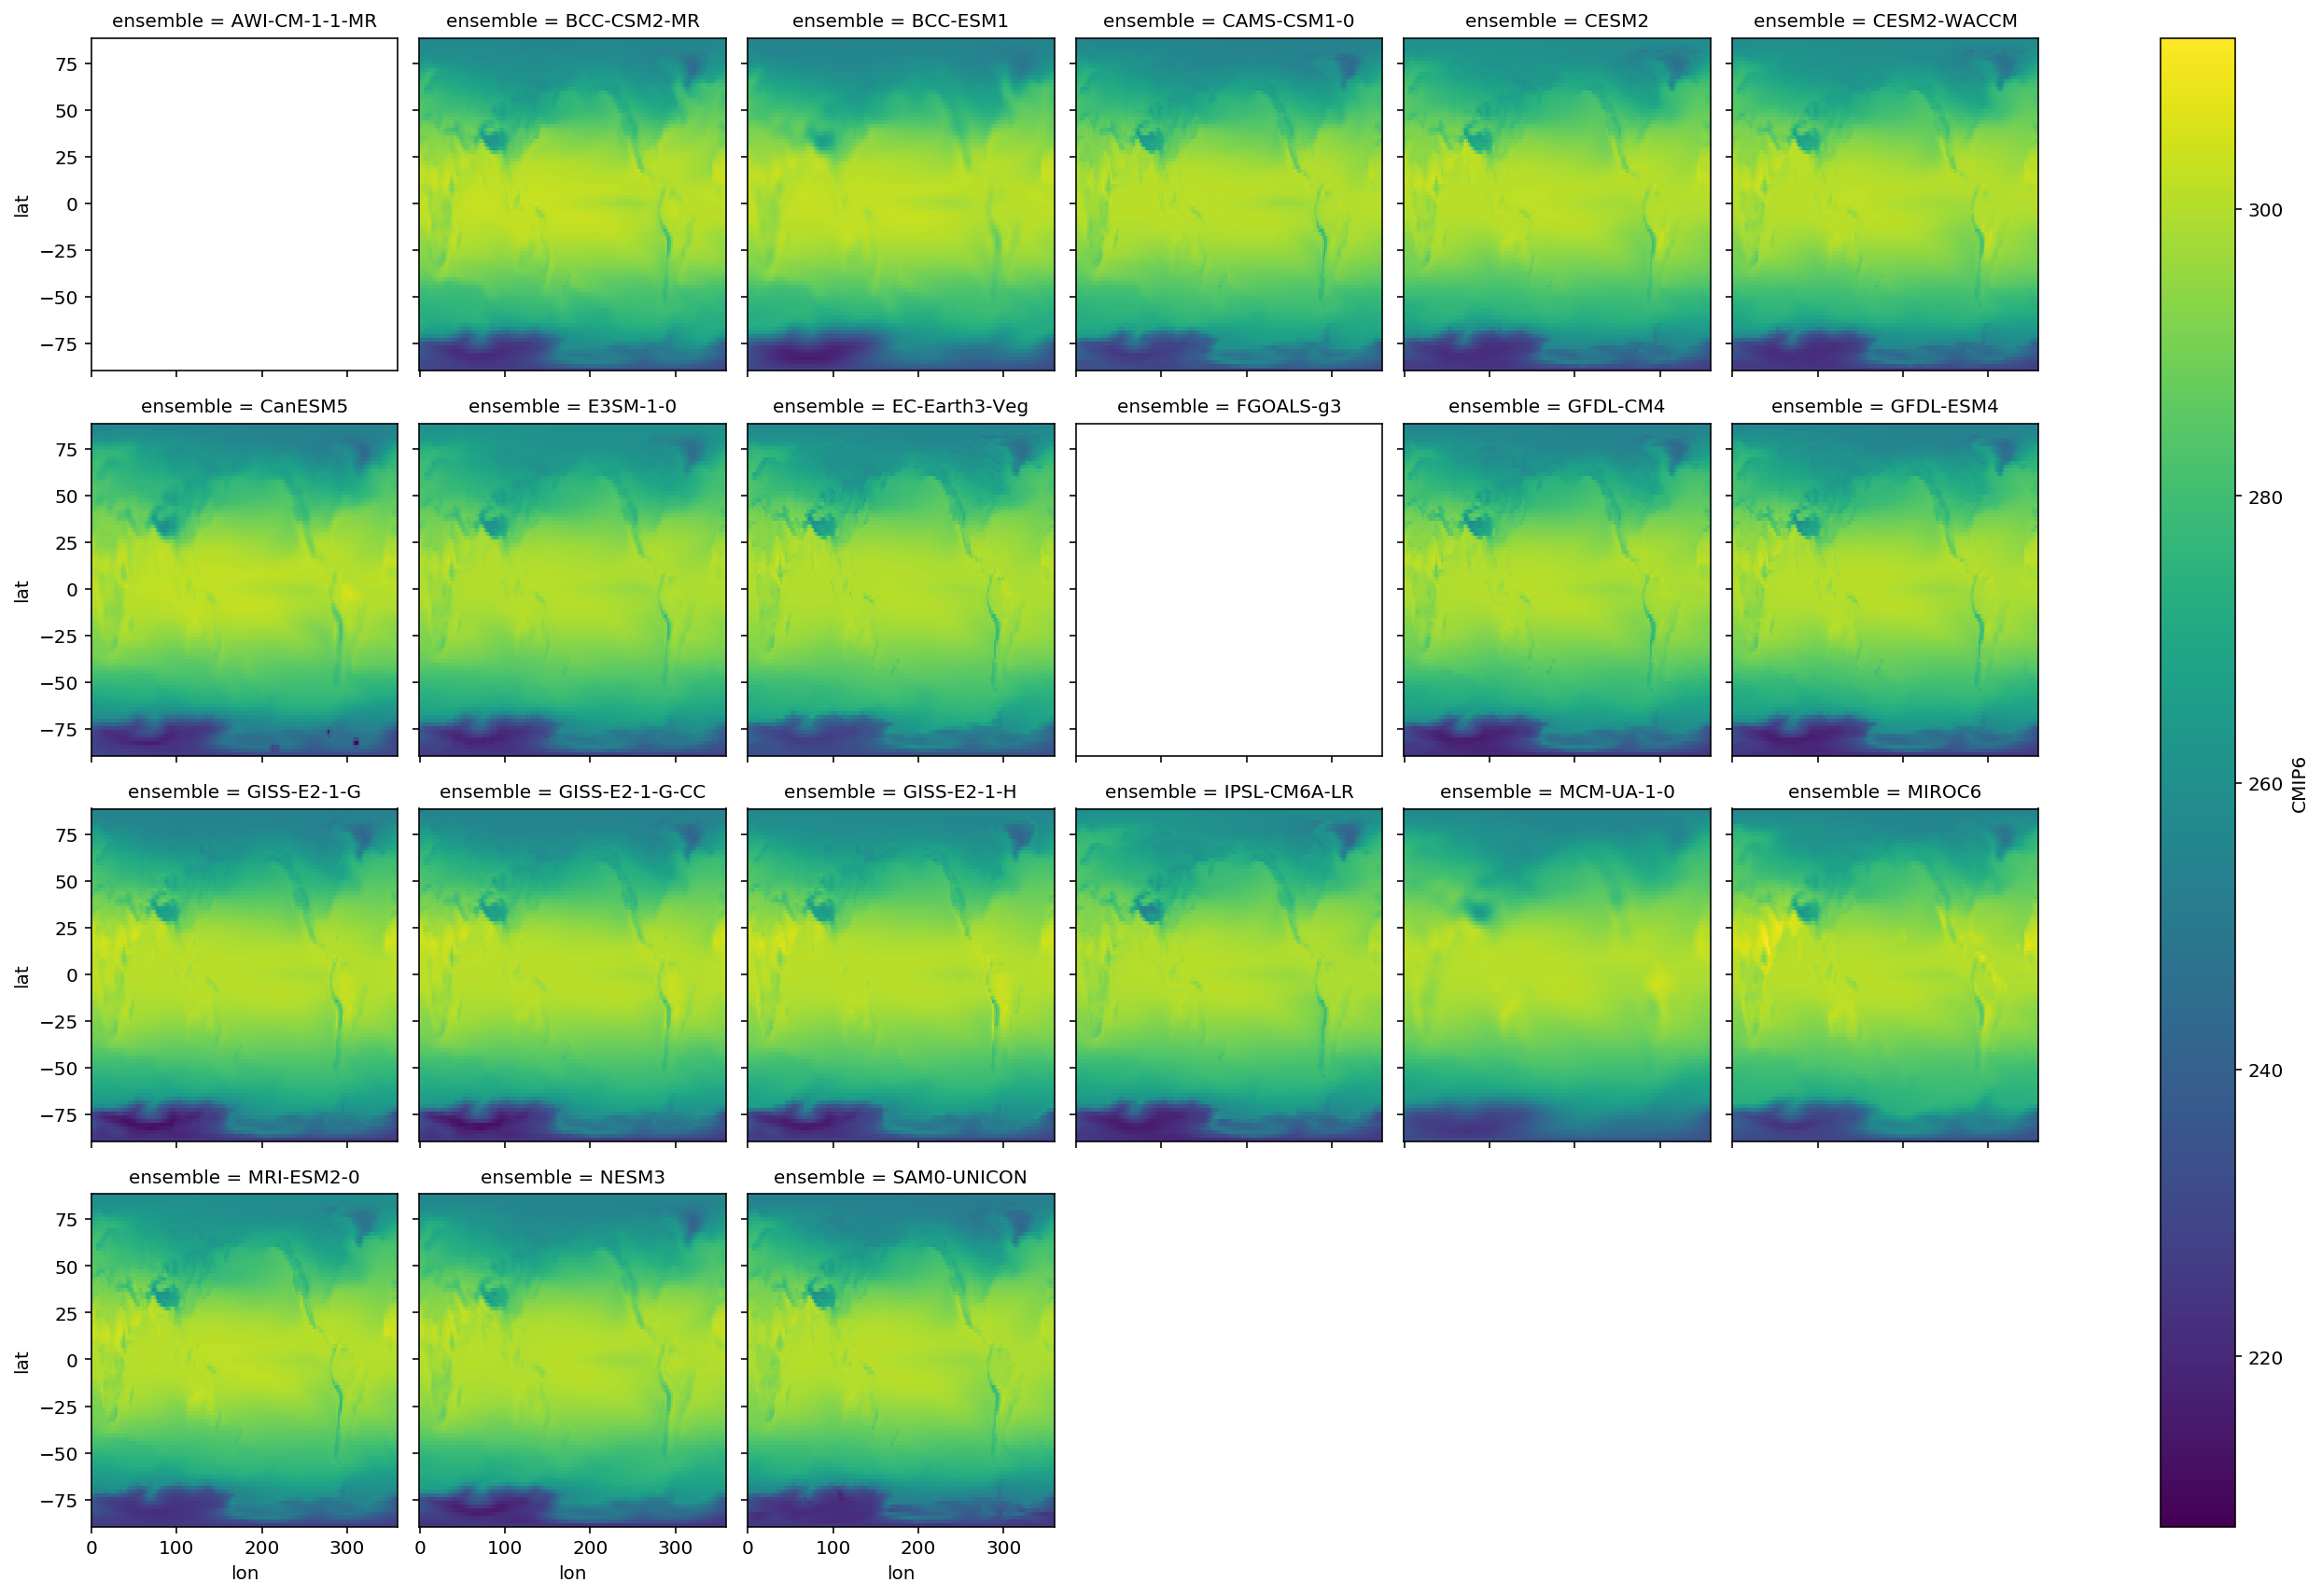

<Figure size 432x288 with 0 Axes>

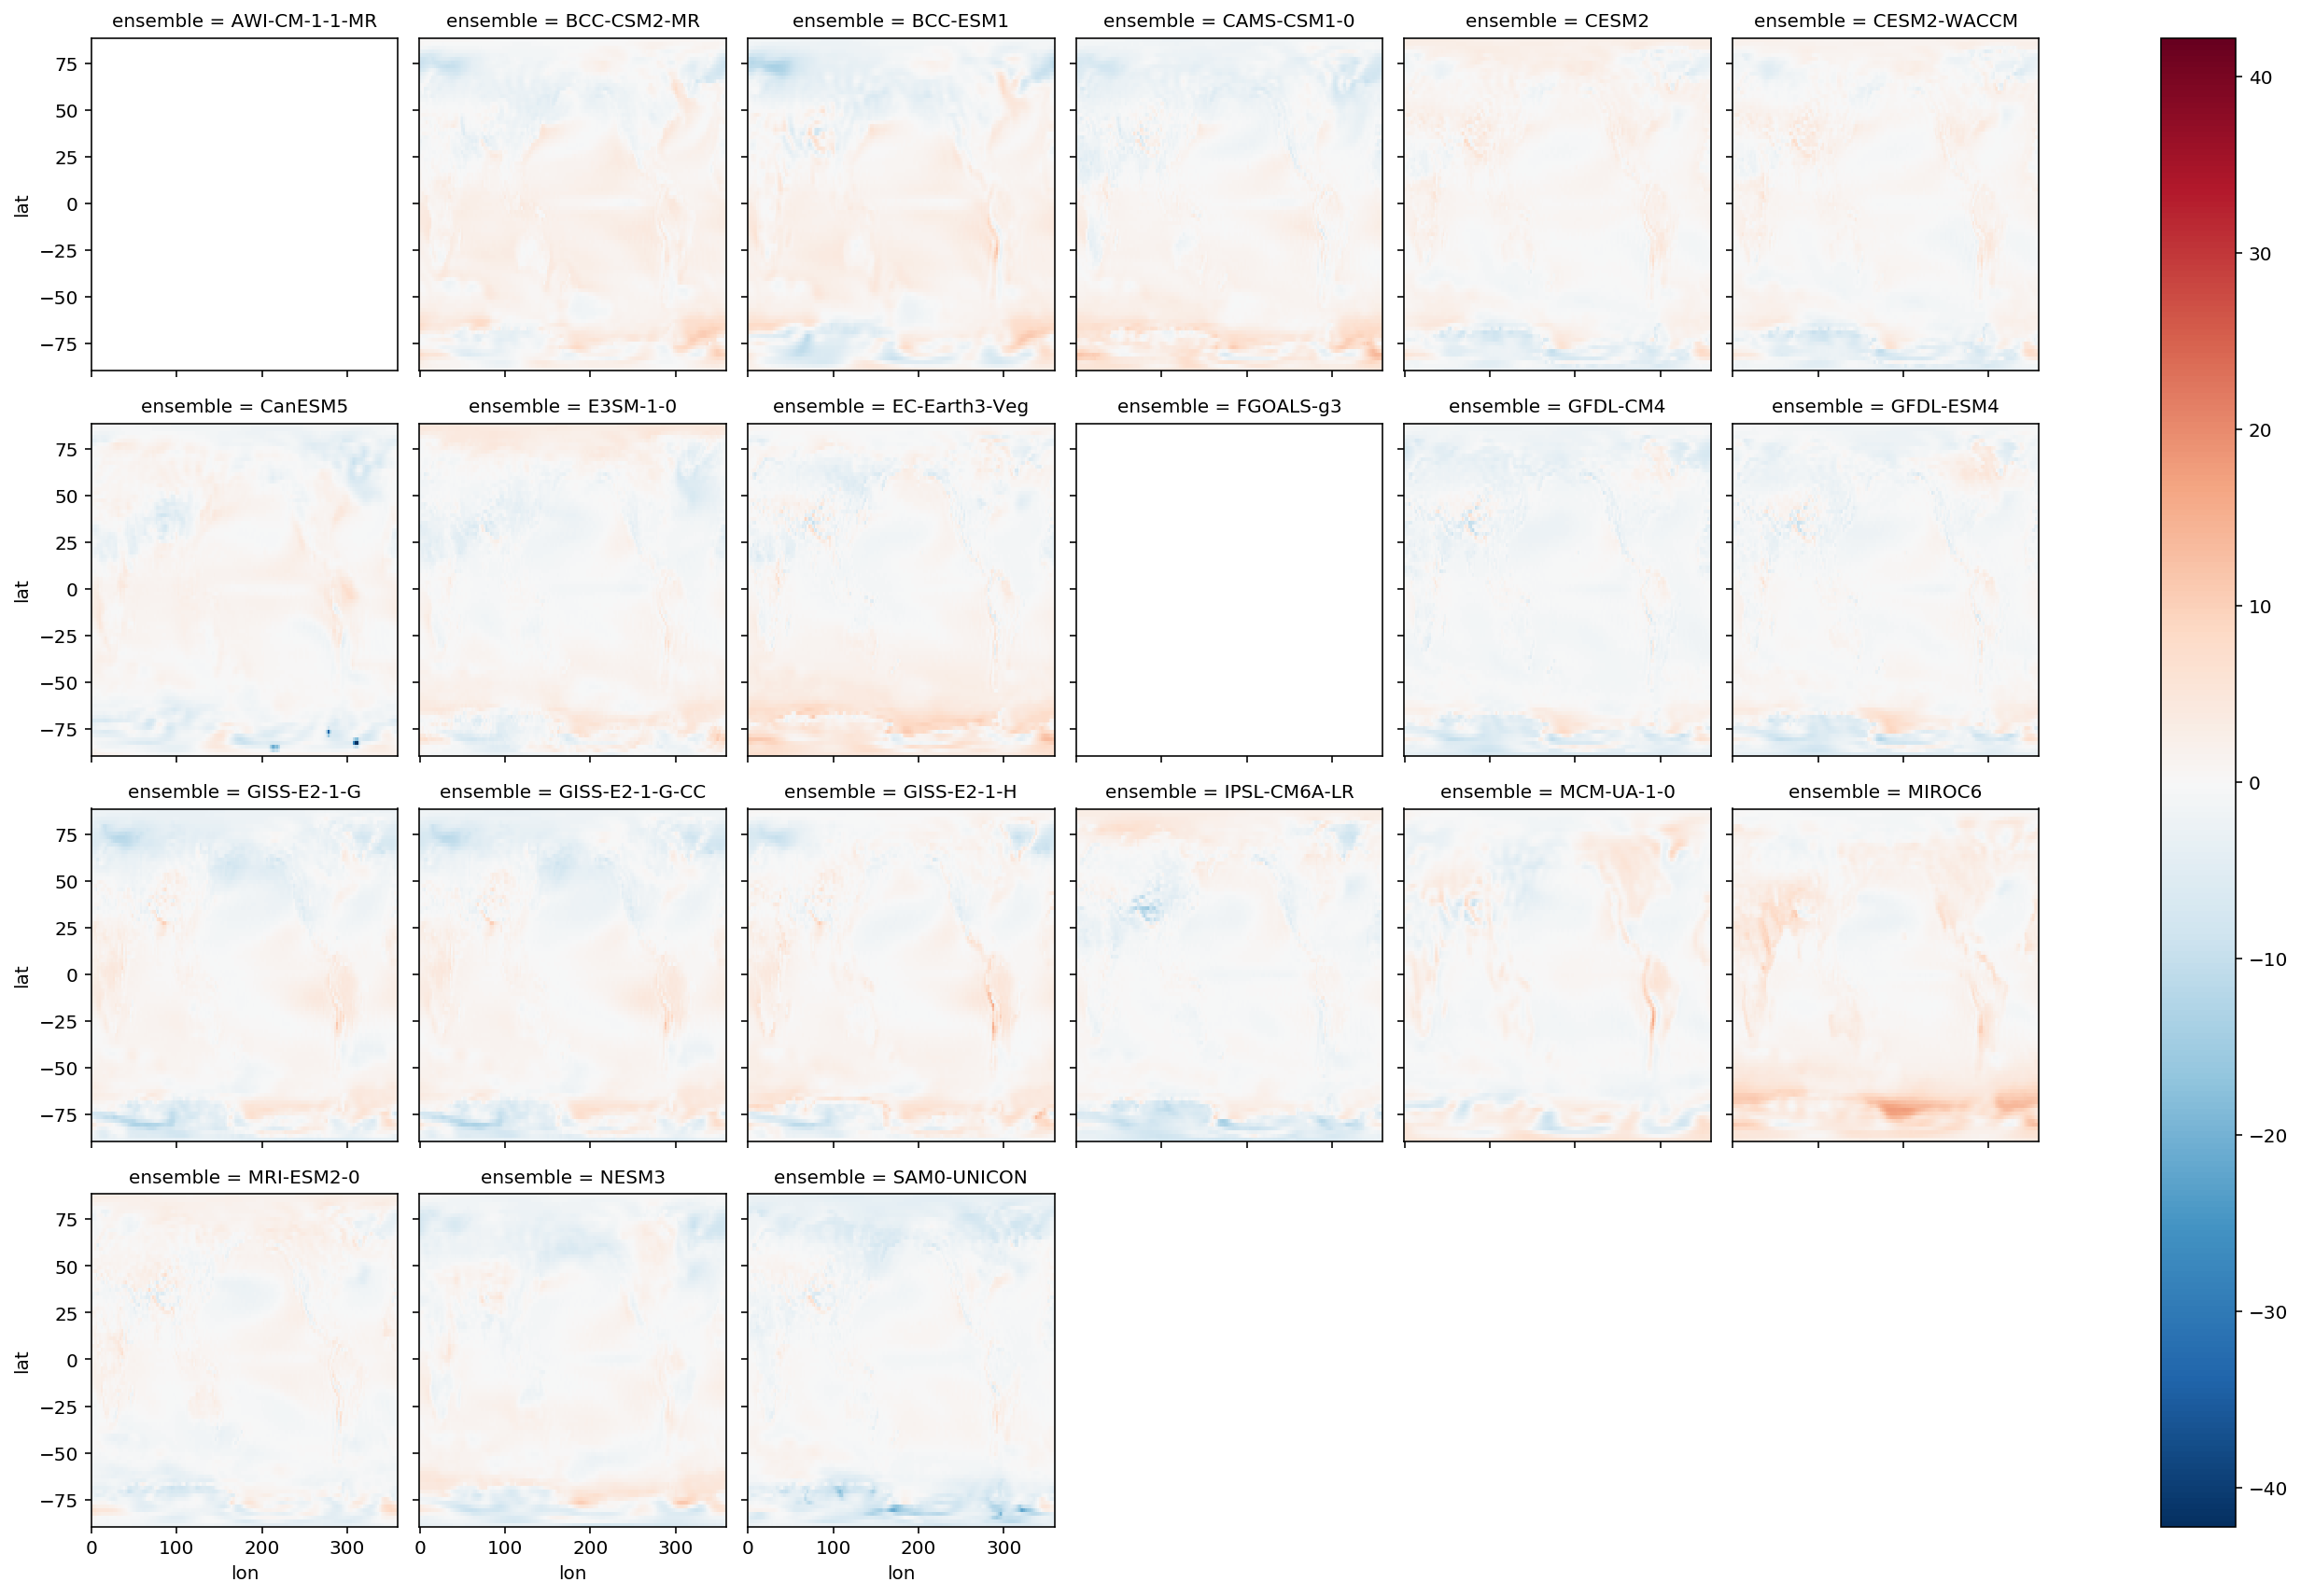

<Figure size 432x288 with 0 Axes>

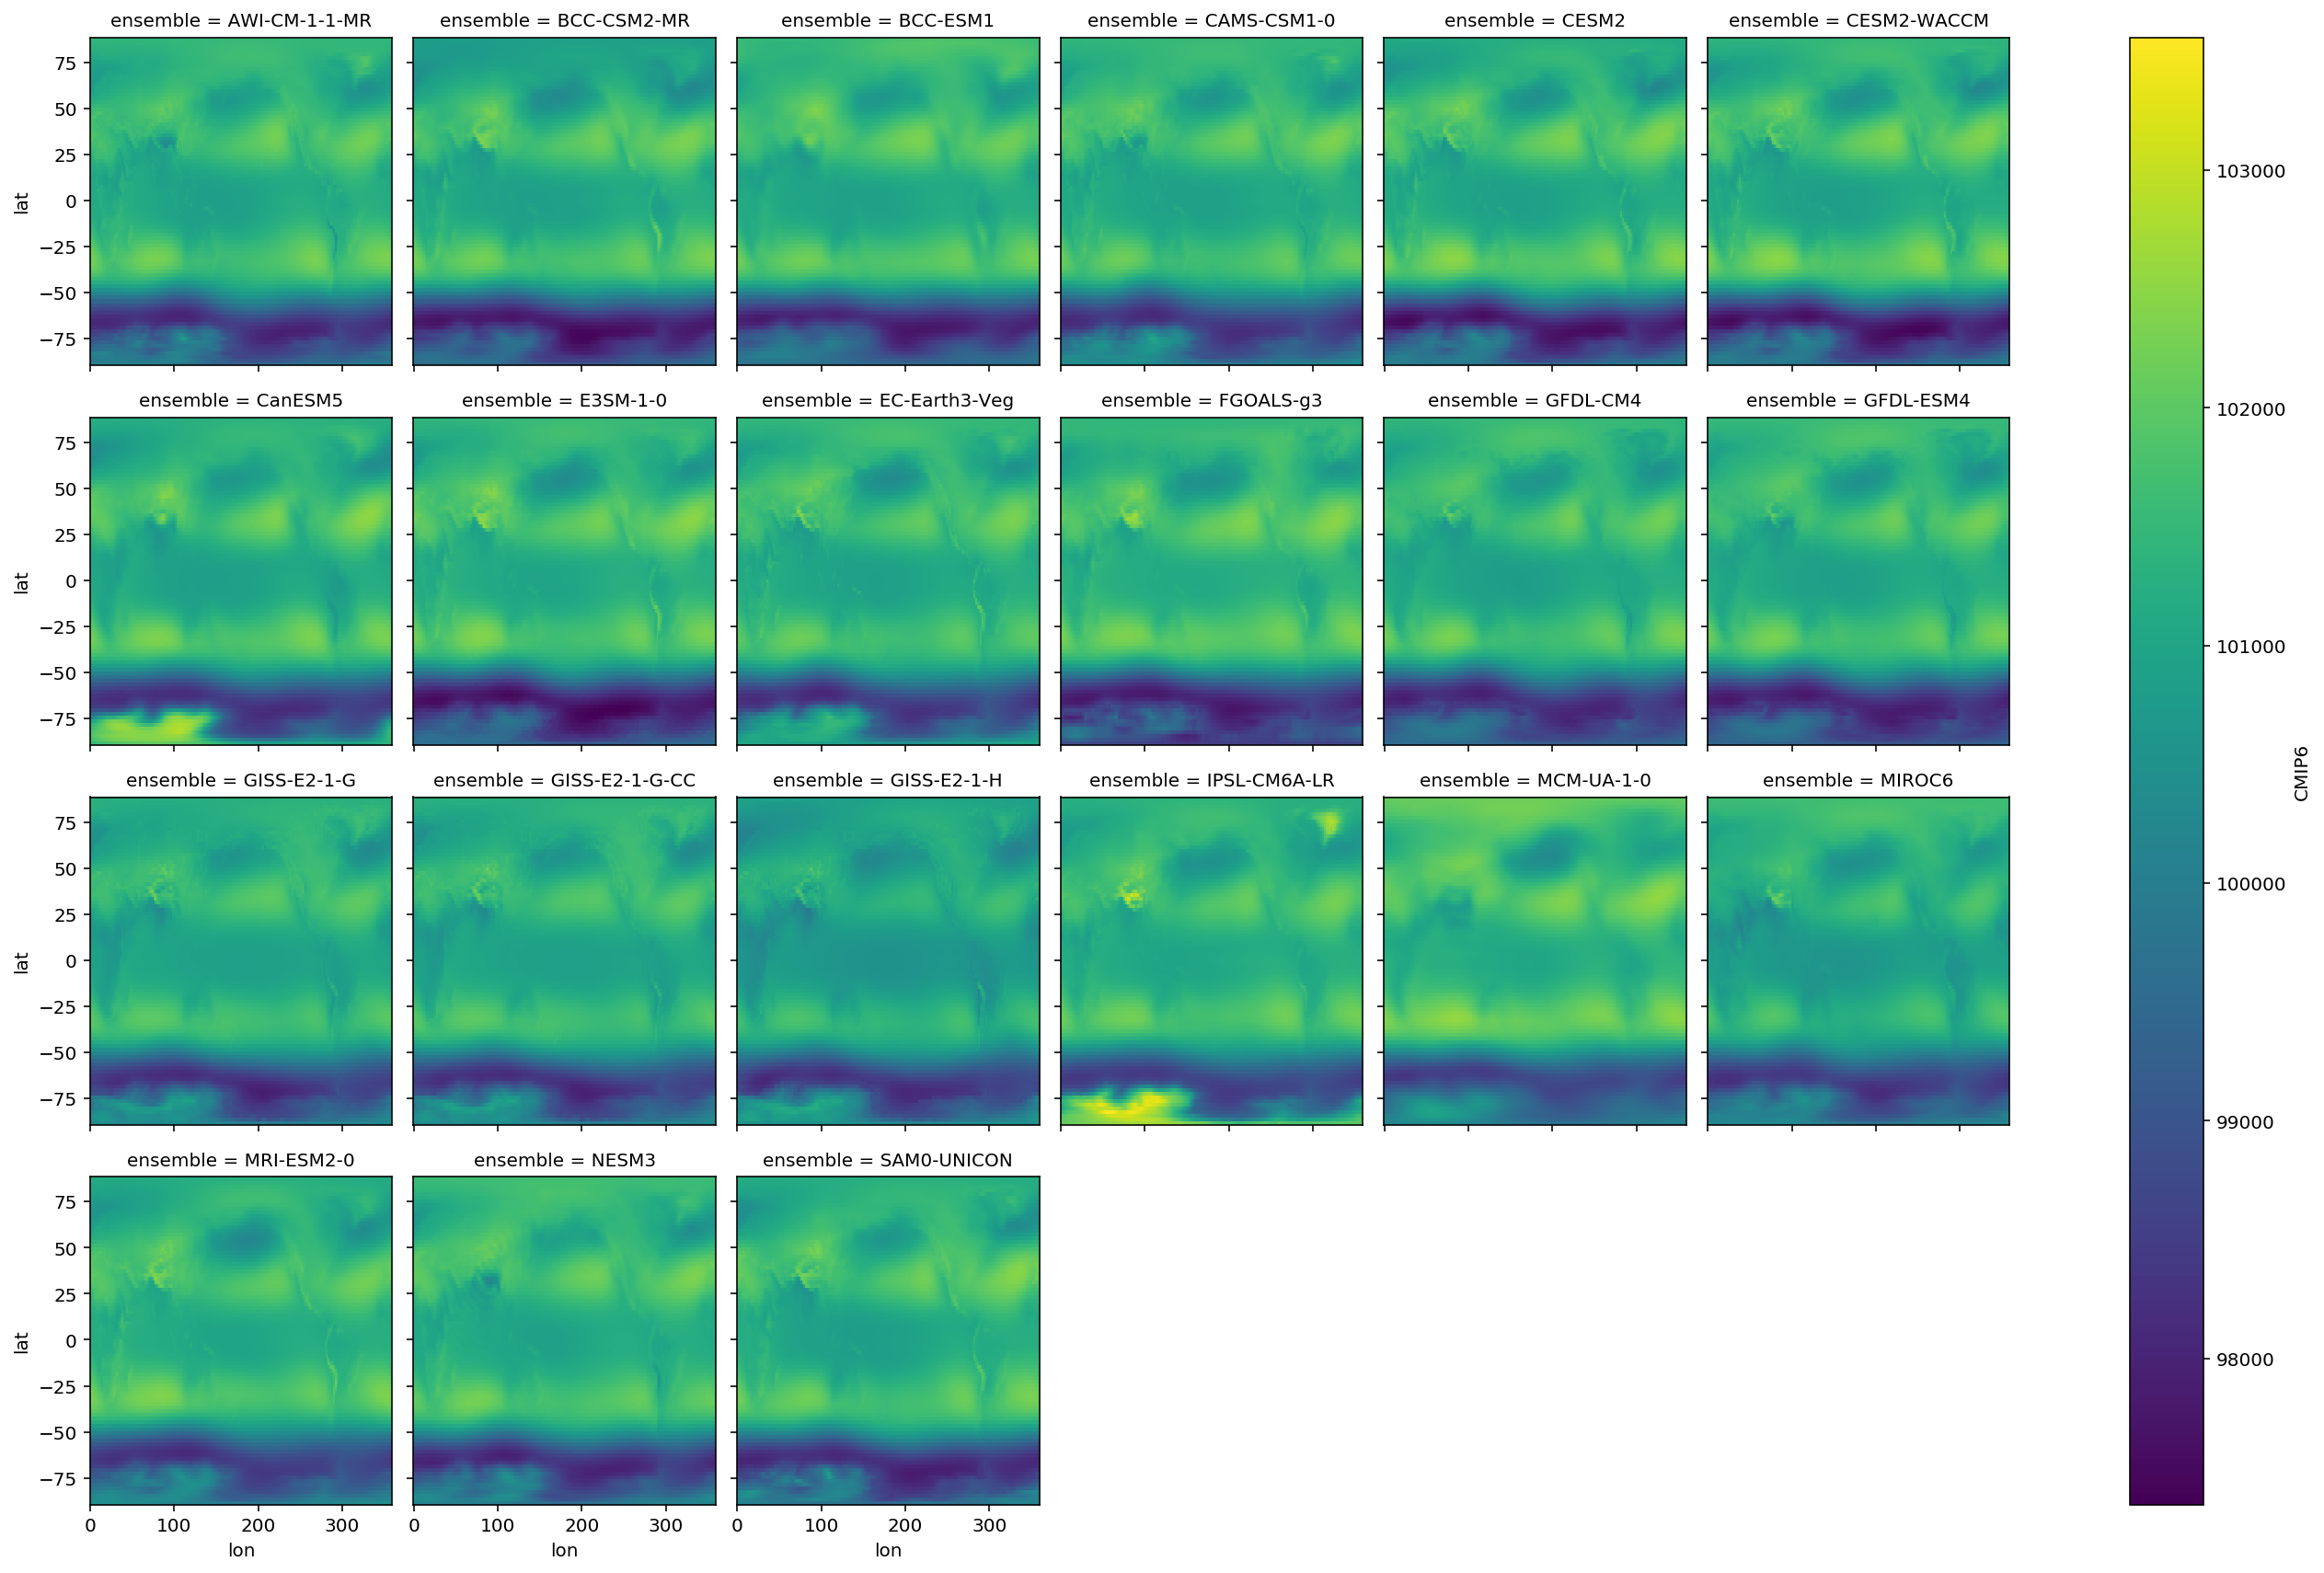

<Figure size 432x288 with 0 Axes>

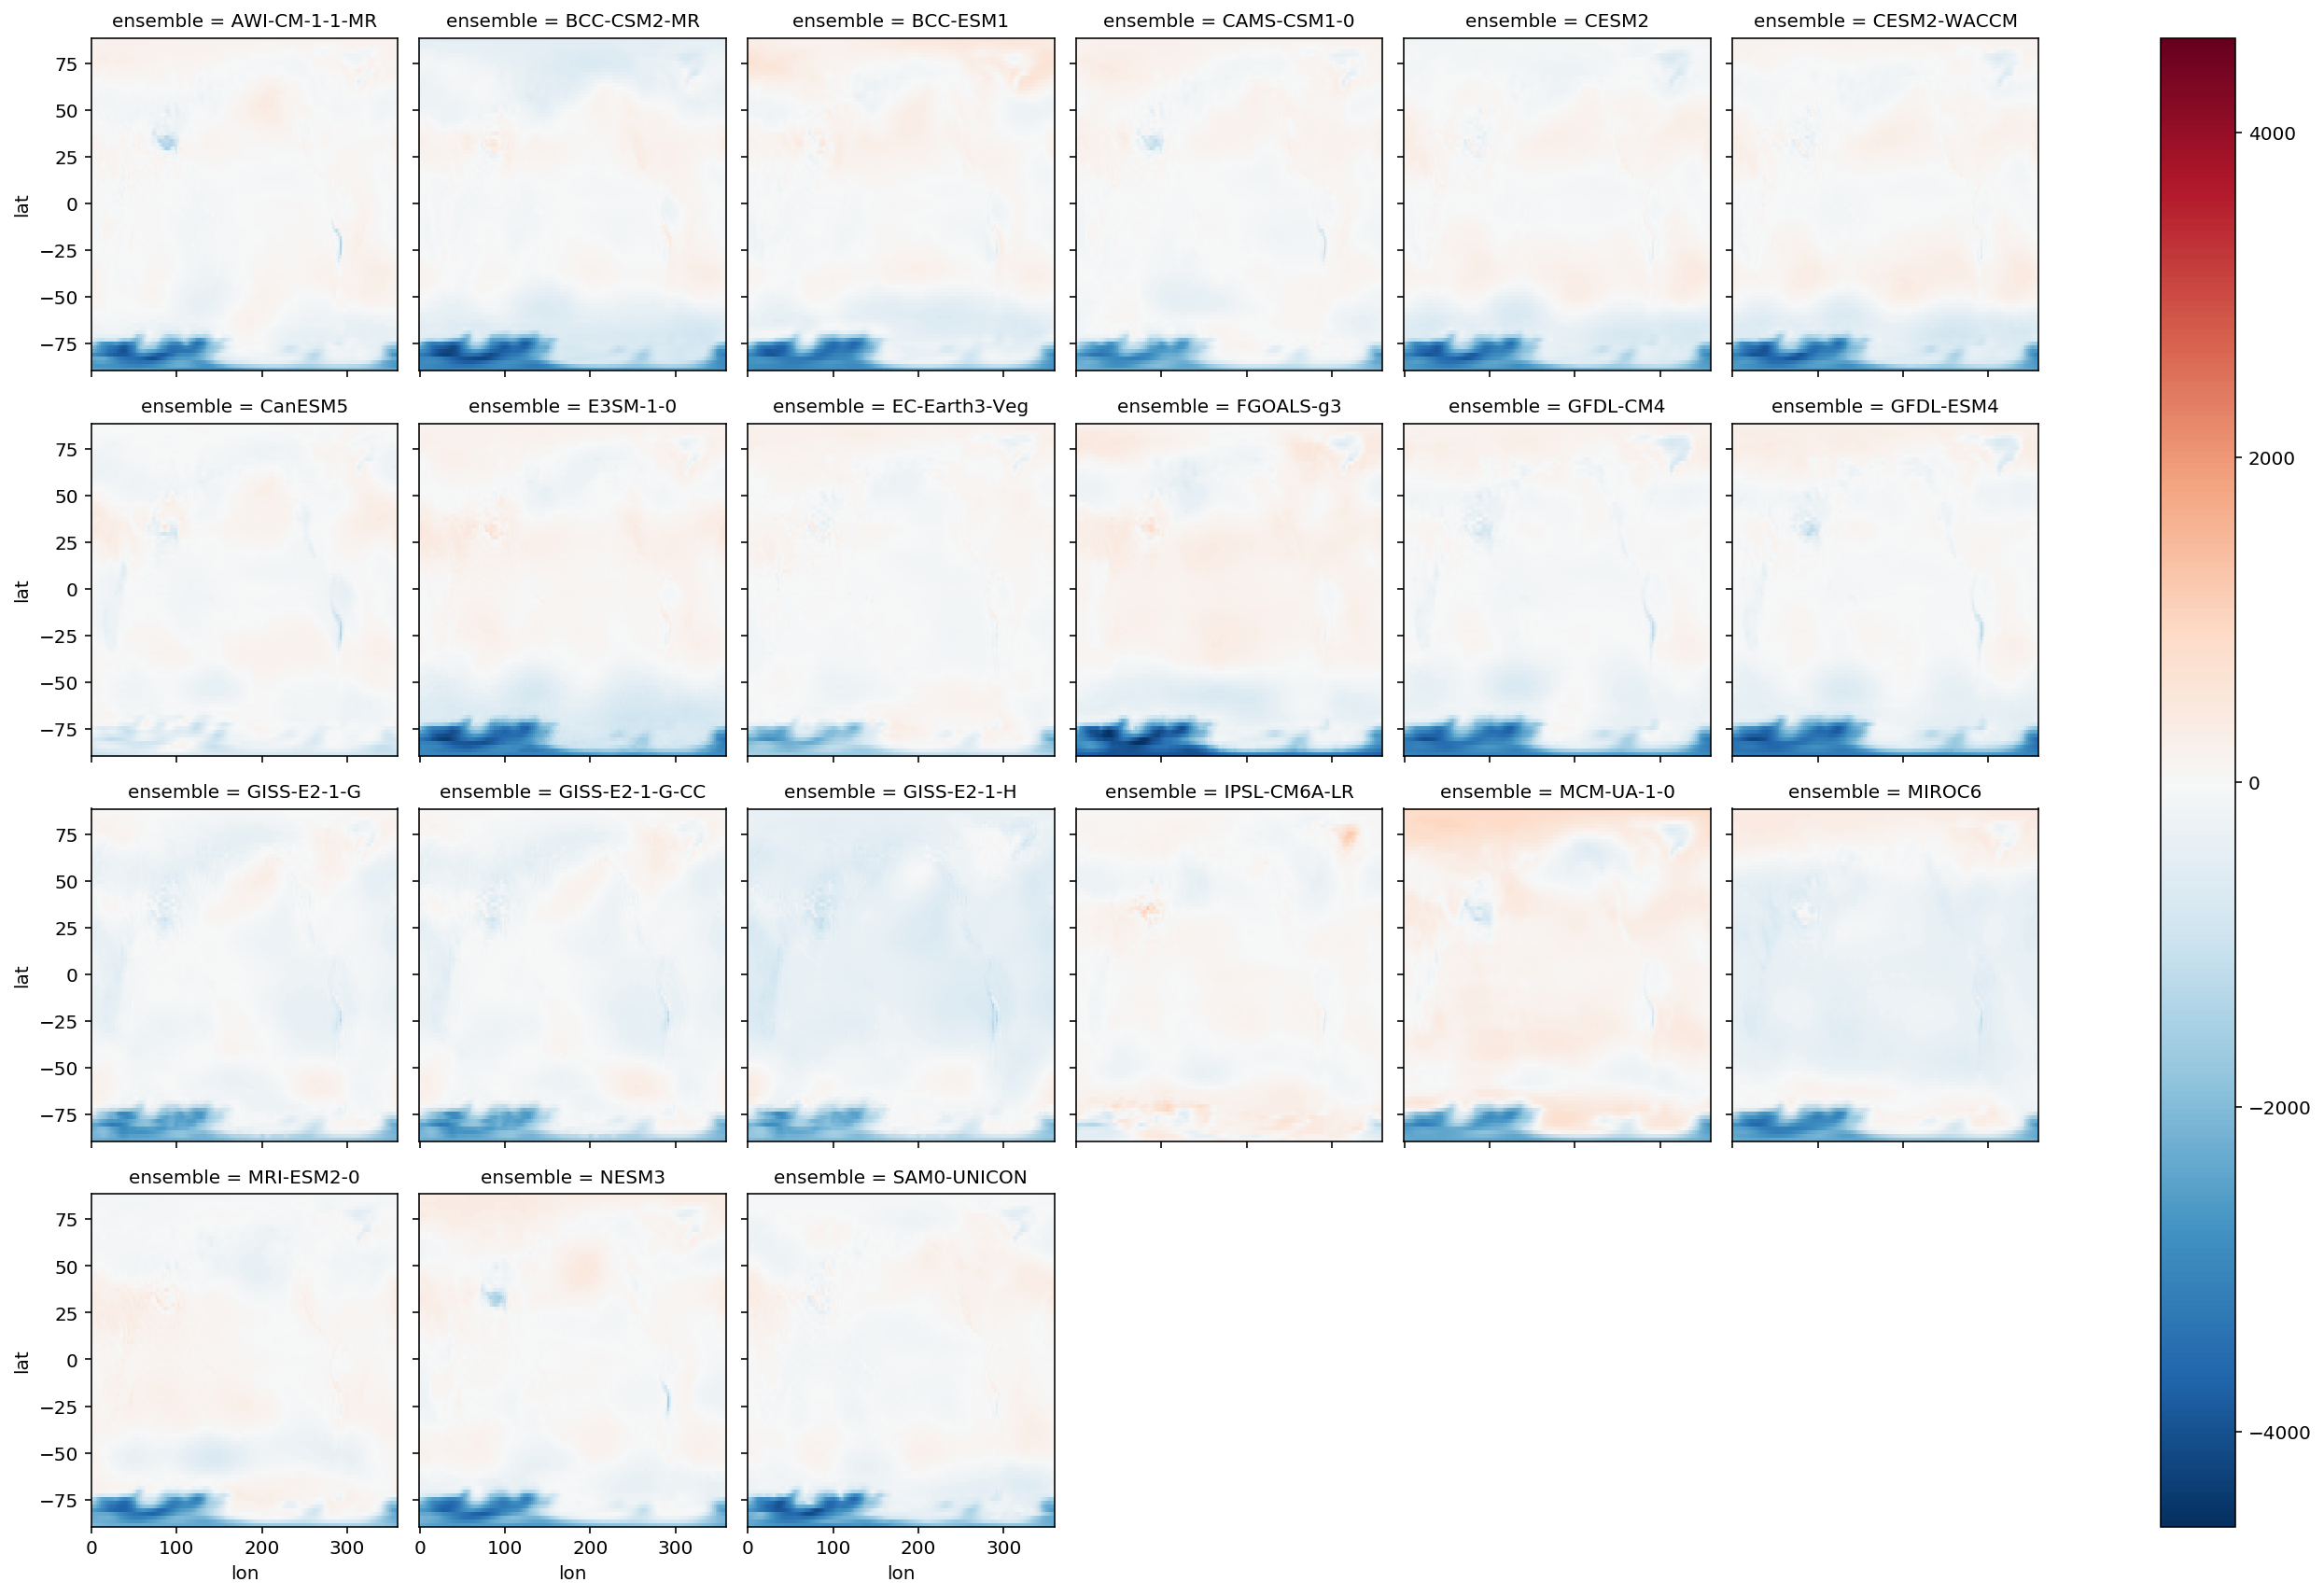

<Figure size 432x288 with 0 Axes>

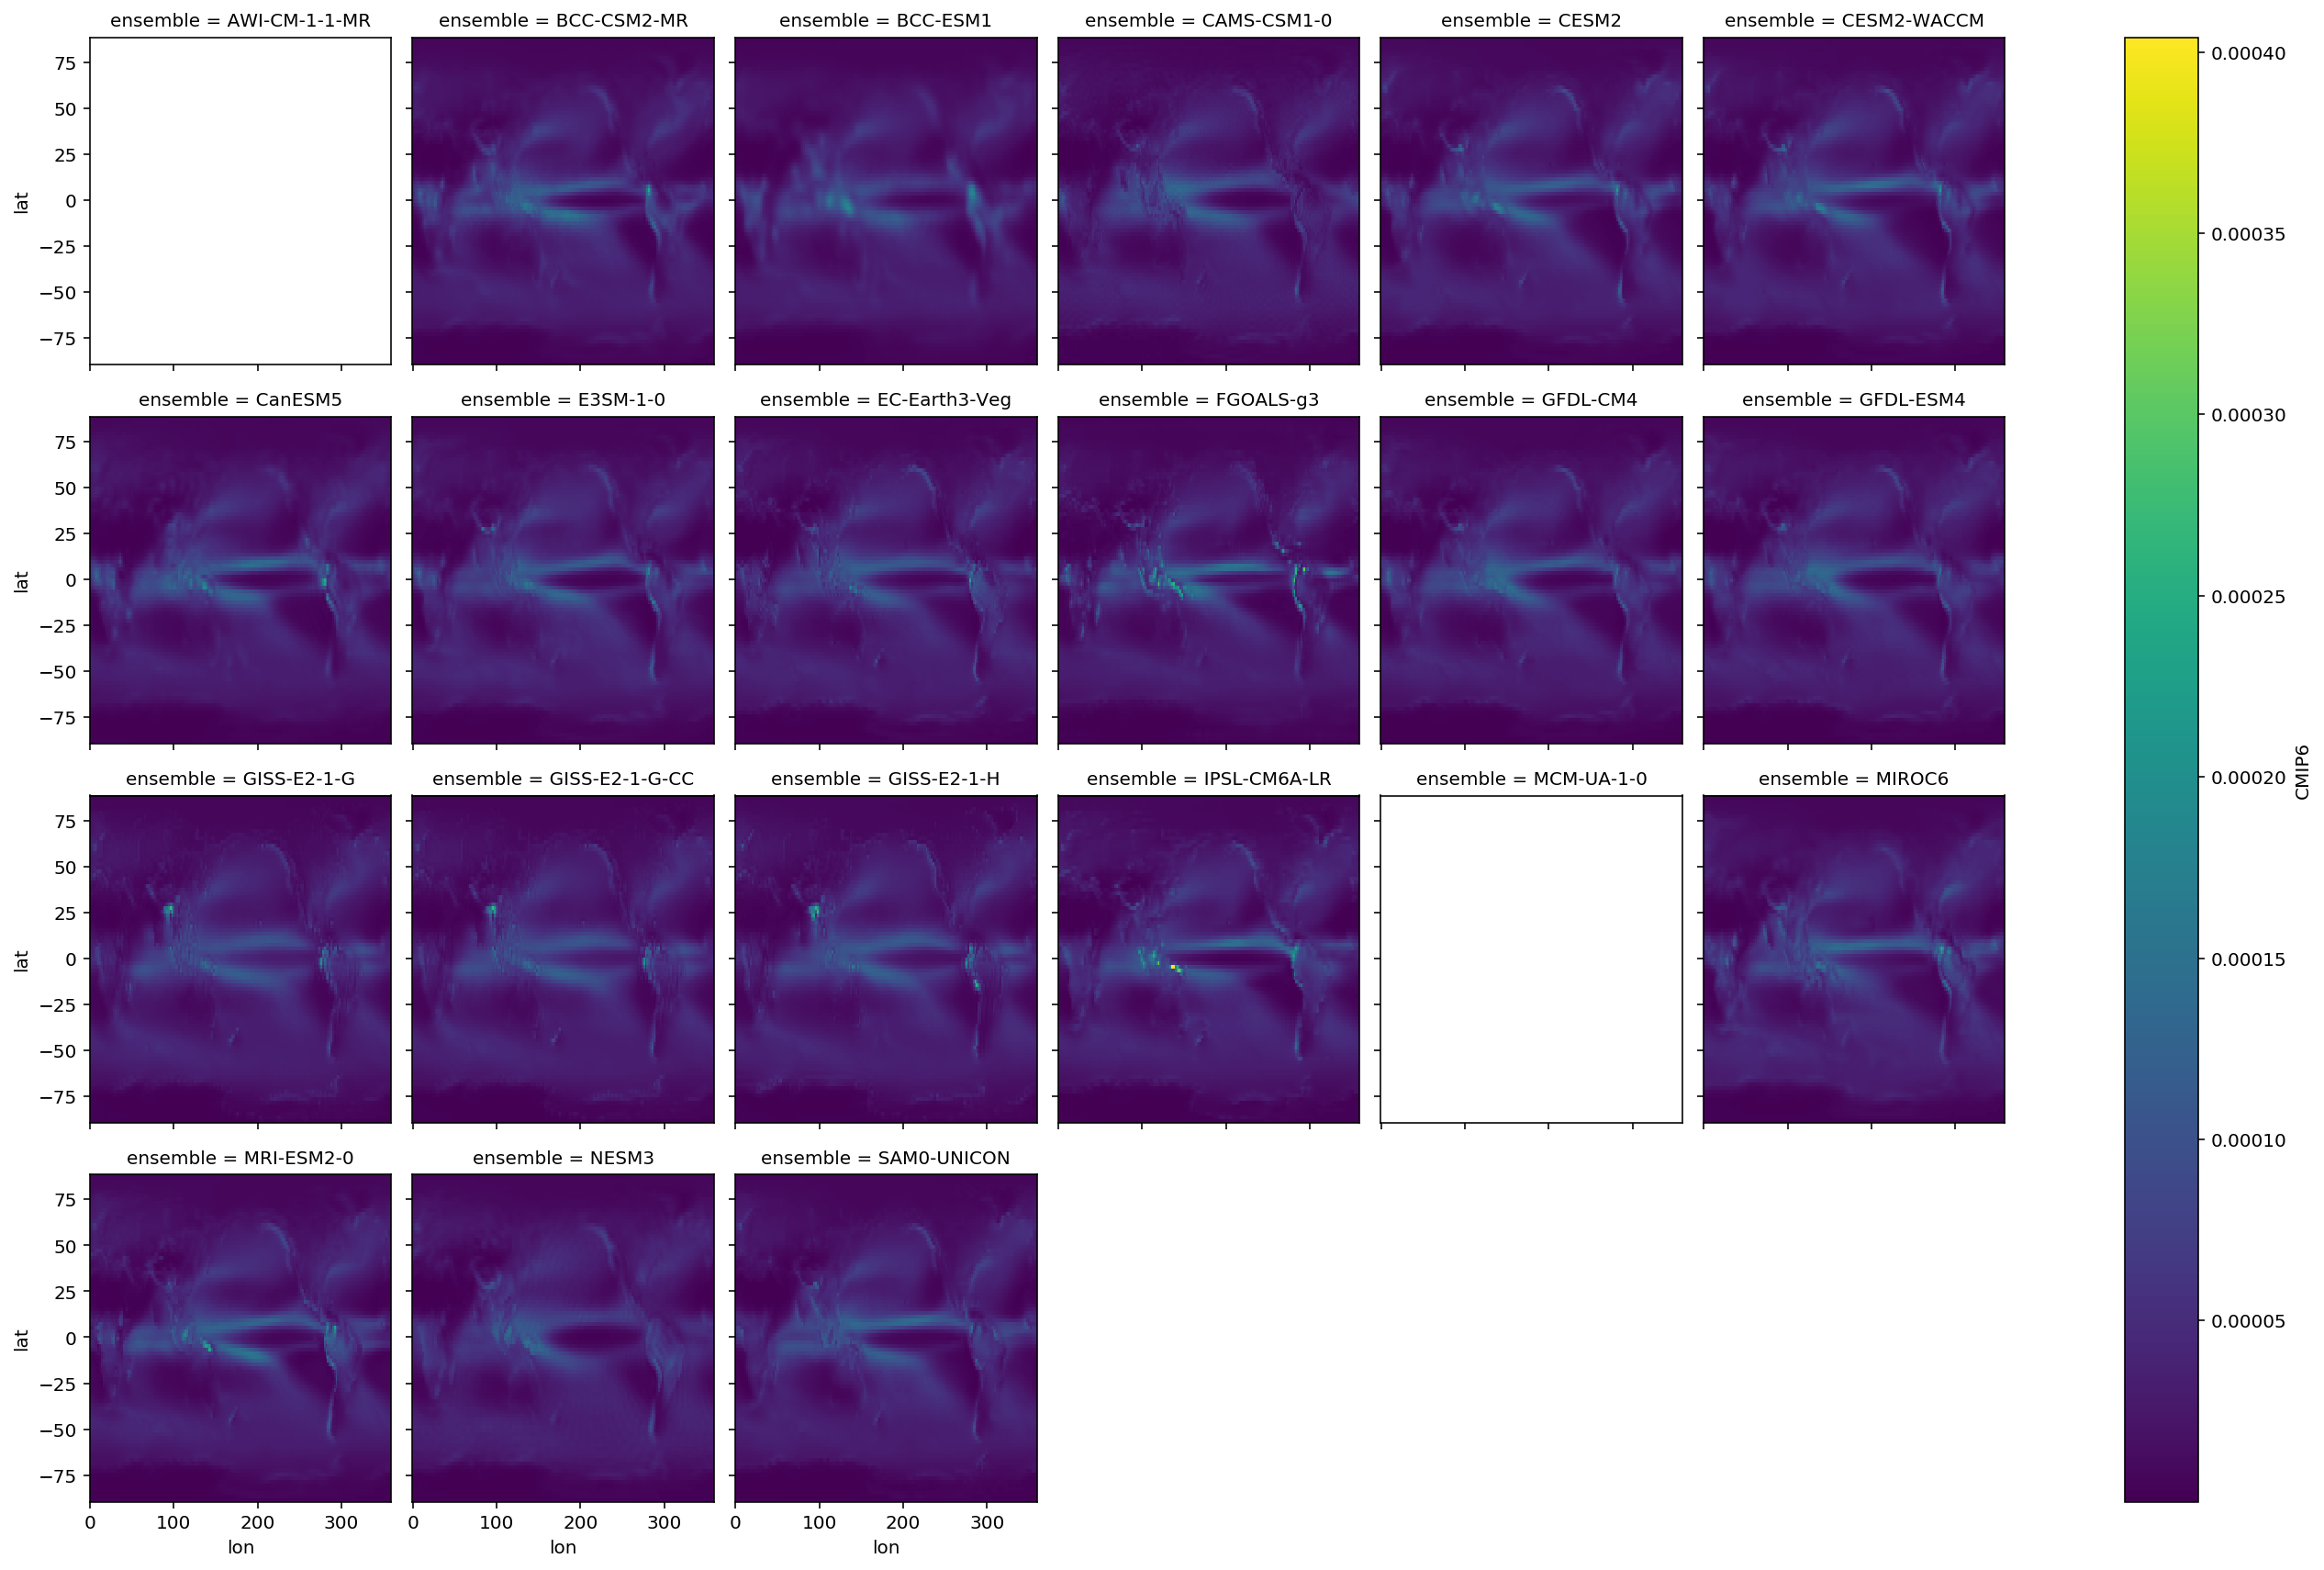

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

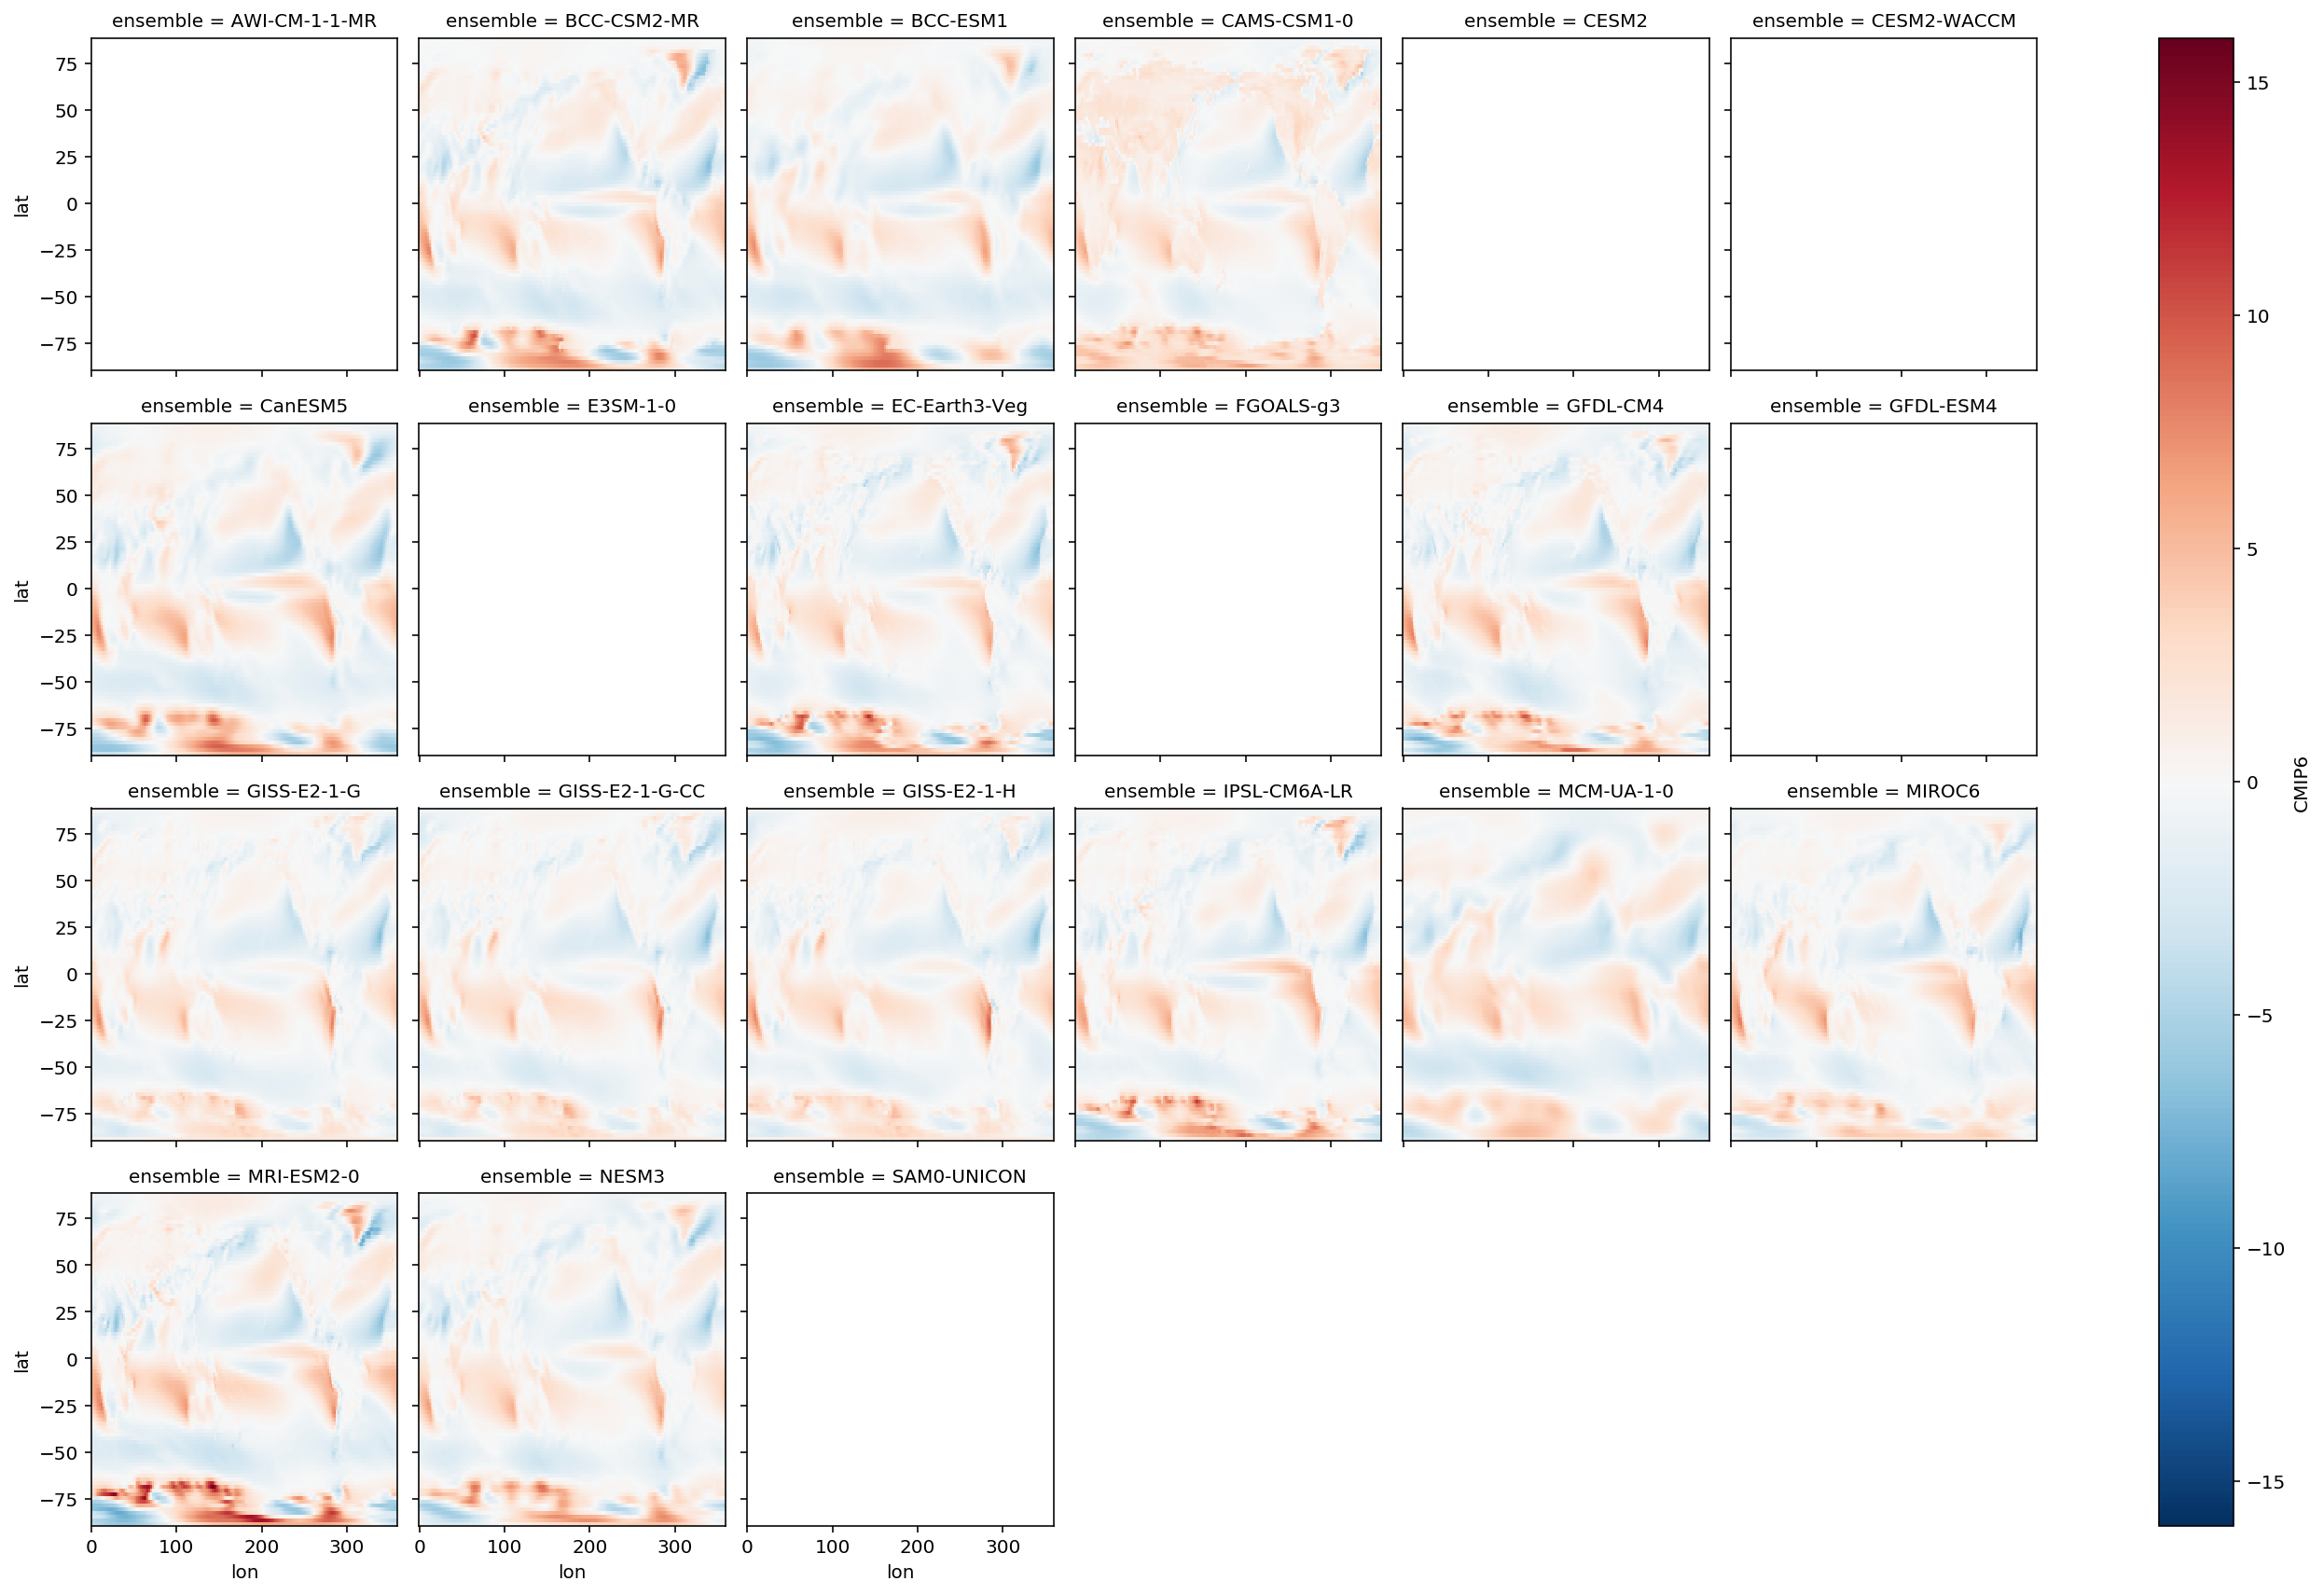

<Figure size 432x288 with 0 Axes>

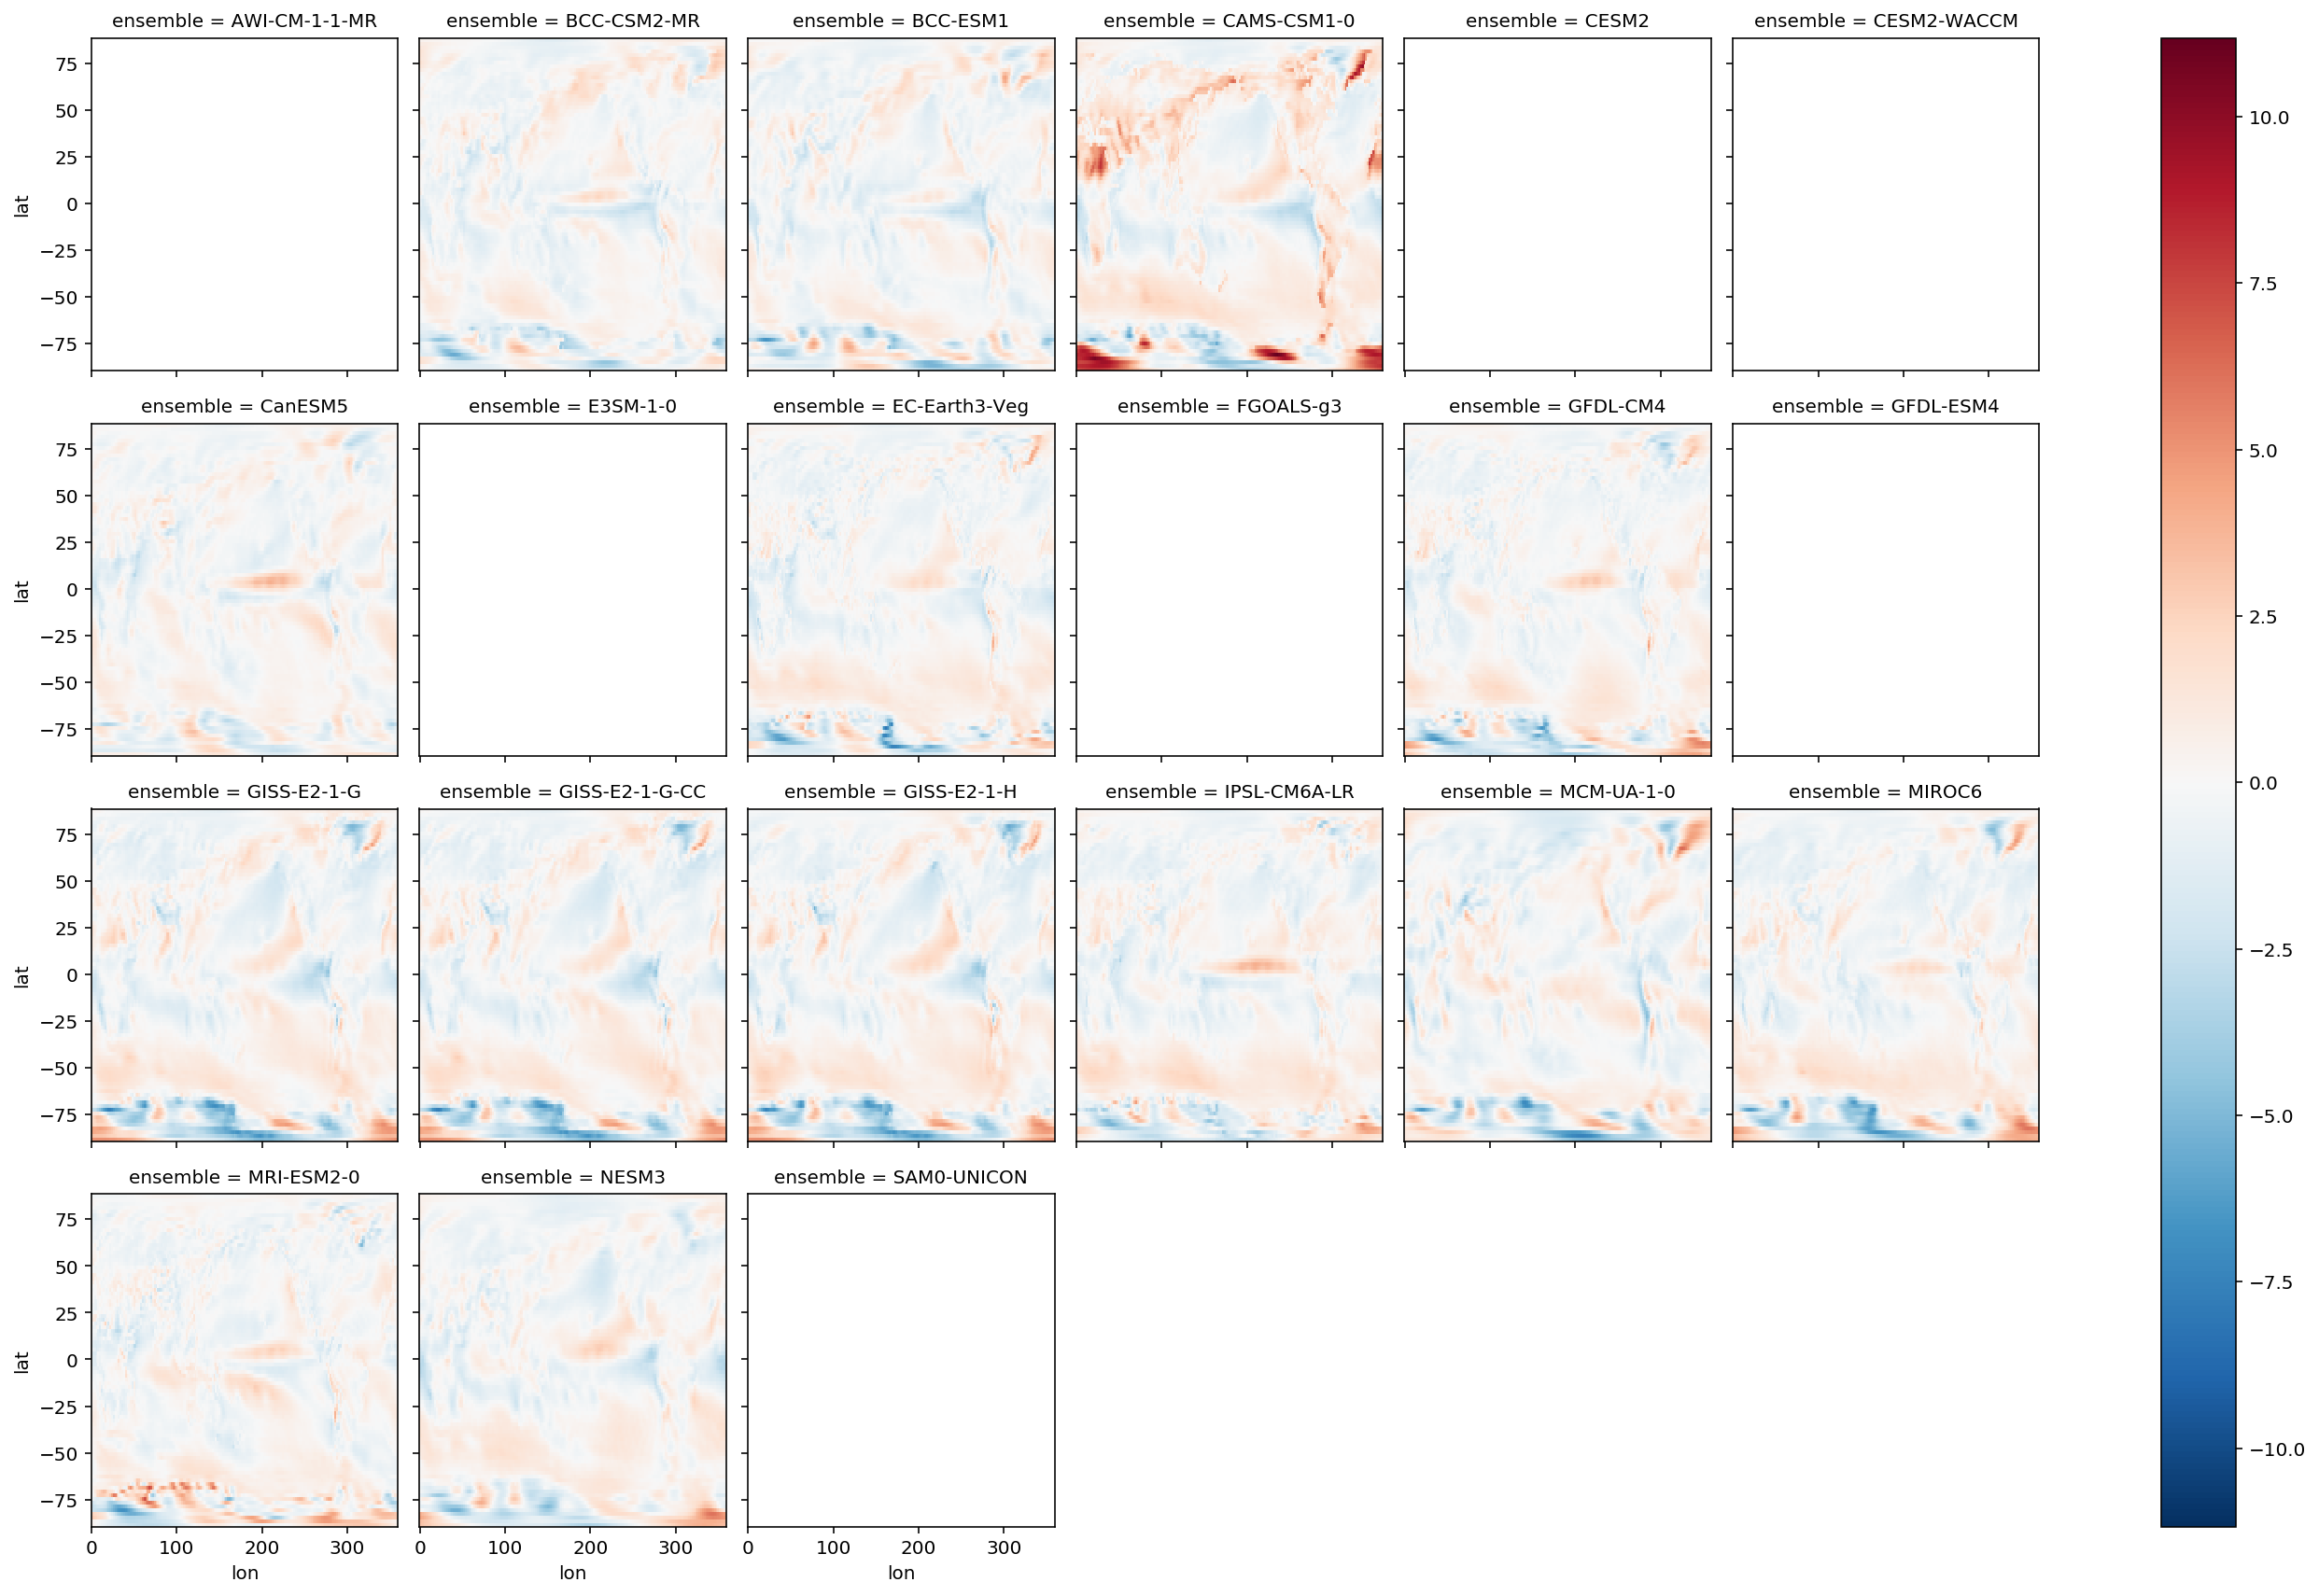

In [9]:
for varname in varnames:
    # Plot mean state
    plt.figure()
    q = ens.sel(var=varname).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

    # Plot anomalies with respect to observations (temporarily, actually multi-model mean)
    plt.figure()
    q = (ens-ncep).sel(var=varname).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
    # How to change color bar limits?

In [10]:
rmse = xs.rmse(ncep, ens, ['lat', 'lon']).compute()

In [11]:
rmse_med = rmse.median(dim='ensemble').compute()
skill_score = rmse/rmse_med

In [12]:
def carpet_plot(da):
    coords = list(da.coords)
    q = plt.pcolormesh(da.values, cmap='RdYlBu_r')
    plt.yticks(np.arange(da.coords[coords[0]].size)+0.5, list(da.coords[coords[0]].values))
    plt.xticks(np.arange(da.coords[coords[1]].size)+0.5, list(da.coords[coords[1]].values), rotation=90.)
    plt.colorbar()
    plt.clim([0.5,1.5])
    return q

In [18]:
plt.figure(figsize=(12,6))
q = carpet_plot(skill_score)
q.colorbar.set_label("normalized model error")